### Imports

In [753]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn import linear_model, metrics, preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score, f1_score
from sklearn.preprocessing import LabelEncoder


import matplotlib.pyplot as plt


### Sanitize Data

In [754]:
def sanitize_data(df):
    for col in df:
        df.loc[(df[col] == 'לא זמין') | (df[col] == 'יעודכן בקרוב'), col] = None    

    df['תאריך כניסה לזאפ'] = pd.to_numeric(df['תאריך כניסה לזאפ'].str.replace('מ','').str.replace('עד','').str.strip())
    df['נפח זיכרון RAM'] = pd.to_numeric(df['נפח זיכרון RAM'].str.replace('GB','').str.strip())
    df['מהירות מעבד'] = pd.to_numeric(df['מהירות מעבד'].str.replace('Mhz','').str.replace('MHz','').str.strip())
    df['דור מעבד'] = pd.to_numeric(df['דור מעבד'].str.replace('דור','').str.strip())
    df['גודל מסך'] = pd.to_numeric(df['גודל מסך'].str.replace('אינטש','').str.strip())
    df["קצב רענון תצוגה"] = pd.to_numeric(df["קצב רענון תצוגה"].str.lower().str.replace('hz','').str.strip())
    df.loc[(df["סוג הזכרון"] == "לא רלוונטי") | (df["סוג הזכרון"] == "DDRAM"), "סוג הזכרון"] = None
    df["סוג הזכרון"] = pd.to_numeric(df["סוג הזכרון"].str.replace('DDR','').str.strip())
    
    df['כונן קשיח'] = df['כונן קשיח'].str.replace('GB','').str.strip()
    for i in range(len(df['כונן קשיח'])):
        if i == 200:
            x = 5
        if not df.loc[i, 'כונן קשיח']:
            continue
        arr = df.loc[i, 'כונן קשיח'].replace(",","+").split("+")
        if len(arr) > 1:
            sum = 0
            for num in arr:
                sum += int(num)
            df.loc[i, 'כונן קשיח'] = sum
        else:
            df.loc[i, 'כונן קשיח'] = int(arr[0])

    
    df['רזולוציית מסך'] = df['רזולוציית מסך'].str.replace('X','x')
    df['משקל'] = df['משקל'].str.replace('ק"ג','').str.strip()
    df['משקל']= pd.to_numeric(df['משקל'])
    
    df['מחיר מקסימלי'] = pd.to_numeric(df['מחיר מקסימלי'].str.replace(',',''))
    df['מחיר מינימלי'] = pd.to_numeric(df['מחיר מינימלי'].str.replace(',','' ))
    df=df.dropna()
    df['מחיר'] = (df['מחיר מקסימלי'] + df['מחיר מינימלי'])/2
    df['מחיר'] = (df['מחיר'] - df['מחיר'].min()) / (df['מחיר'].max() - df['מחיר'].min())
    df = df.drop(["מחיר מקסימלי" , "מחיר מינימלי" ] , axis = 1)    
    return df

### Features

In [755]:
def features(df):
    df['מסך מגע']  = np.where(df['מסך מגע']  == "כולל" , 1 , 0)
    df['כונן אופטי']  = np.where(df['כונן אופטי']  == "כולל" , 1 , 0)
    df['מודם סלולארי']  = np.where(df['מודם סלולארי']  == "כולל" , 1 , 0)
    df['התאמה לגיימינג']  = np.where(df['התאמה לגיימינג']  == "גיימינג" , 1 , 0)

    cond_dict = {
        'מתקפל':500,
        'מסך מסתובב':750,
        'מסך נשלף':1000,
        'ללא':0,
        'לא זמין':0,
        'לא רלוונטי':0
    }
    df['תוספת מחיר']=df['תצורת ‎ 2 in 1'].map(cond_dict)
    # df['רזולוציית מסך'] = df['רזולוציית מסך'].fillna('0x0') 
    df['רזולוציית מסך'] = df['רזולוציית מסך'].apply(lambda s: int(s.split('x')[0]) *int(s.split('x')[1]))
    df['רזולוציית מסך'] = (df['רזולוציית מסך'] - df['רזולוציית מסך'].min()) / (df['רזולוציית מסך'].max() - df['רזולוציית מסך'].min())    

    df = df.drop(["תצורת ‎ 2 in 1" ] , axis = 1) 
    return df  

In [756]:
def categorial_to_numerical(df, columns):
    return pd.get_dummies(df, columns=columns)


### Helper Functions

In [757]:
def create_heatmap(numeric_df):
    first_col = numeric_df.pop('מחיר')
    numeric_df.insert(0, 'מחיר', first_col)
    numeric_df =numeric_df.rename(columns=lambda x: x[::-1])
    sns.heatmap(numeric_df.corr())

In [758]:
def load_dataset(df, target_column):
    return df.drop([target_column],axis = 1),df[target_column]

In [759]:
def train_1st_model(X_train, y_train):
    reg = LinearRegression(fit_intercept = False)
    return reg.fit(X_train,y_train)
    

In [760]:
def predict_1st(trained_1st_model, X_test):
    return trained_1st_model.predict(X_test)

In [761]:
def evaluate_performance_1st(y_test,y_predicted):
    return metrics.r2_score(y_test,y_predicted)

In [762]:
def predict(df):
    numeric_df = df.select_dtypes(include='number')
    X_1st_train, y_1st_train = load_dataset(numeric_df,'מחיר')
    X_1st_test, y_1st_test = load_dataset(numeric_df, 'מחיר')
    trained_model_1st = train_1st_model(X_1st_train, y_1st_train)
    pred_1st_vals = predict_1st(trained_model_1st, X_1st_test)


    y_pred_1st= pd.Series(pred_1st_vals,index=X_1st_test.index)
    eval_res_1st = evaluate_performance_1st(y_1st_test, y_pred_1st)
    return eval_res_1st

### Data Analysis

#### Before Features

C:\Users\shayr\AppData\Local\Temp\ipykernel_21020\1770280169.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['מחיר'] = (df['מחיר מקסימלי'] + df['מחיר מינימלי'])/2
C:\Users\shayr\AppData\Local\Temp\ipykernel_21020\1770280169.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['מחיר'] = (df['מחיר'] - df['מחיר'].min()) / (df['מחיר'].max() - df['מחיר'].min())


prediction: 0.7073069720708172


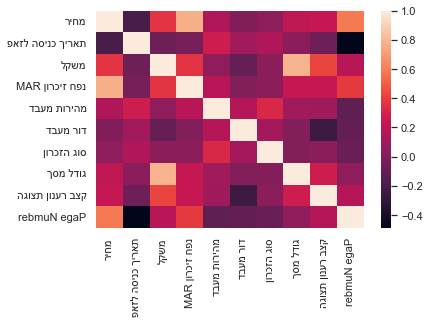

In [763]:
df = pd.read_csv('test3.csv')
df = sanitize_data(df)
before = df.select_dtypes(include='number')
create_heatmap(before)
print('prediction:', predict(before))

prediction: 0.7415312732031162


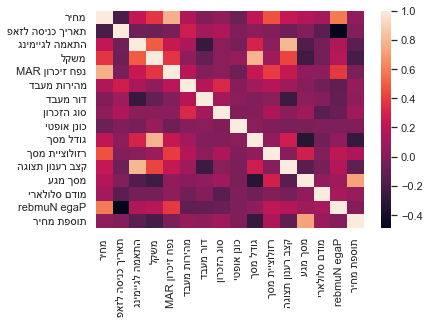

In [764]:
df = features(df)
print('prediction:', predict(df))
create_heatmap(df)

In [765]:
after = categorial_to_numerical(df,['כרטיס מסך','סדרה'])
print('prediction:', predict(after))

prediction: 0.9466786920607131


In [766]:
after = categorial_to_numerical(after,['יצרן','סוג מעבד'])
print('prediction:', predict(after))

prediction: 0.9578318696117916


### Violin

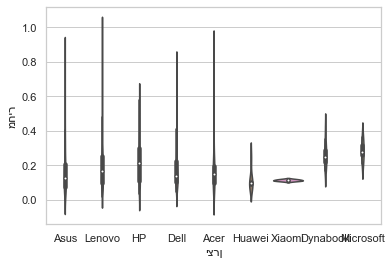

In [767]:
df_violin = df[['מחיר','יצרן']]
# df_violin = categorial_to_numerical(df_violin,['יצרן'])
# df = df.drop(["יצרן" ] , axis = 1) 
sns.set_theme(style="whitegrid")
ax = sns.violinplot(y="מחיר", x="יצרן", data=df_violin)

# print(df_violin)